# 그리드 서치 구현

* 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도해보는 것

## 간단한 그리드 서치 구현

* SVC의 모델의 gamma, C 매개변수 설정

In [1]:
from ml1.preamble import*

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print(f'훈련 세트의 크기 {X_train.shape[0]}  테스트 세트의 크기: {X_test.shape[0]}')

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma': gamma}

print(f'최고 점수: {best_score:.2f}')
print(f'최적 매개변수: {best_parameters}')

훈련 세트의 크기 112  테스트 세트의 크기: 38
최고 점수: 0.97
최적 매개변수: {'C': 100, 'gamma': 0.001}


=> 테스트 세트를 모델의 매개변수를 고르는데 사용했으므로 검증 세트가 따로 필요함

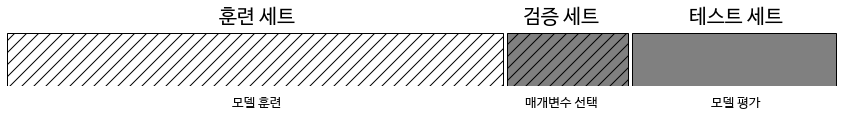

In [2]:
mglearn.plots.plot_threefold_split()

## 검증 세트를 사용한 그리드 서치 구현

In [3]:
from sklearn.svm import SVC

X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma': gamma}

svc = SVC(**best_parameters).fit(X_trainval, y_trainval)
test_score = svc.score(X_test, y_test)
print(f'검증 세트에서 최고 점수: {best_score:.2f}')
print(f'최적 매개변수: {best_parameters}')
print(f'최적 매개변수에서의 테스트 세트 점수: {test_score:.2f}')

검증 세트에서 최고 점수: 0.96
최적 매개변수: {'C': 10, 'gamma': 0.001}
최적 매개변수에서의 테스트 세트 점수: 0.92


=> 앞서 예상한 97%가 아니라 92%의 정확도를 가진다고 볼 수 있음

## 교차 검증을 사용한 그리드 서치 구현

* 일반화 성능을 더 잘 평가하기 위해 교차 검증을 사용해서 각 매개변수 조합의 성능을 평가할 수 있음

In [4]:
from sklearn.model_selection import cross_val_score

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        
        svm = SVC(gamma=gamma, C=C)
        score = cross_val_score(svm, X_trainval, y_trainval, cv=5).mean()
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma': gamma}

svc = SVC(**best_parameters).fit(X_trainval, y_trainval)
test_score = svc.score(X_test, y_test)

print(f'검증 세트에서 최고 점수: {best_score:.2f}')
print(f'최적 매개변수: {best_parameters}')
print(f'최적 매개변수에서의 테스트 세트 점수: {test_score:.2f}')

검증 세트에서 최고 점수: 0.97
최적 매개변수: {'C': 10, 'gamma': 0.1}
최적 매개변수에서의 테스트 세트 점수: 0.97


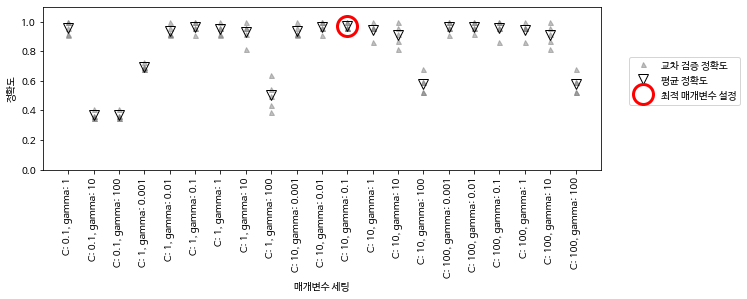

In [5]:
mglearn.plots.plot_cross_val_selection()

# GridSearchCV

* GridSeachCV 객체는 분류기와 비슷해서 fit, predict, score 메서드를 제공

In [6]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print(f'최고 모델의 테스트 세트 점수: {grid_search.score(X_test, y_test):.2f}')
print('최적 매개변수:', grid_search.best_params_)
print(f'최고 교차 검증 점수: {grid_search.best_score_:.2f}')
print('최고 성능 모델:', grid_search.best_estimator_)

최고 모델의 테스트 세트 점수: 0.97
최적 매개변수: {'C': 10, 'gamma': 0.1}
최고 교차 검증 점수: 0.97
최고 성능 모델: SVC(C=10, gamma=0.1)


* GridSearch 결과 분석

In [7]:
pd.set_option('display.max_columns', None)
results = pd.DataFrame(grid_search.cv_results_)
display(np.transpose(results.head()))

,0,1,2,3,4
mean_fit_time,0.001,0.001,0.0006,0.00059,0.0006
std_fit_time,1.6e-05,1.4e-05,0.00049,0.00048,0.00049
mean_score_time,0.0002,0.0002,0.0004,0.0004,0.00059
std_score_time,0.0004,0.00039,0.00049,0.00049,0.00048
param_C,0.001,0.001,0.001,0.001,0.001
param_gamma,0.001,0.01,0.1,1,10
params,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1}","{'C': 0.001, 'gamma': 10}"
split0_test_score,0.35,0.35,0.35,0.35,0.35
split1_test_score,0.35,0.35,0.35,0.35,0.35
split2_test_score,0.36,0.36,0.36,0.36,0.36


* 히트맵으로 시각화

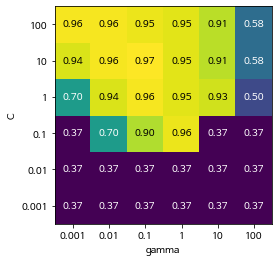

In [8]:
scores = np.array(results.mean_test_score).reshape(6,6)
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'])

## 비대칭 매개변수 그리드 탐색

* SVC는 kernel 이 rbf일때 매개변수로 C와 gamma를 둘 다 쓰지만 kernel이 linear 일때는 C만 씀
* 조건부 매개변수 조합을 적용하려면 param_grid를 딕셔너리의 리스트로 만드어야 함

In [9]:
param_grid = [{'kernel': ['rbf'], 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel' : ['linear'], 'C':[0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print('최적 파라미터:', grid_search.best_params_)
print(f'최고 교차 검증 점수: {grid_search.best_score_:.2f}')

최적 파라미터: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.97


## 중첩 교차 검증

* 특정 데이터셋에서 주어진 모델이 얼마나 잘 일반화되는지 평가
* 새로운 데이터에 적용할 모델을 만드는 것은 아님

In [10]:
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
print('교차 검증 점수', scores)
print('교차 검증 평균 점수: ', round(scores.mean(),2))

교차 검증 점수 [0.967 1.    0.967 0.967 1.   ]
교차 검증 평균 점수:  0.98
